# Trabalho 05 - Classificação

In [1199]:
import pandas as pd
import matplotlib.pyplot as plt
from  scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from AnalysisUtils import print_simple_metrics, boxplot_with_quartiles, create_filtered_histograms

In [1200]:
from sklearn.decomposition import PCA


def load_data():
    return pd.read_csv('data/trabalho5_dados_4.csv')


def preprocess_data(df, categorical_columns, inputting_method):
    # display(((df == 'MD') | df.isna()).sum())
    df = df.replace('MD', np.nan)
    df = fill_missing_data(df, method=inputting_method)

    df['Quantitative Ability 1'] = df['Quantitative Ability 1'].astype(float)
    df['Analytical Skills 1'] = df['Analytical Skills 1'].astype(float)
    df['Domain Skills 1'] = df['Domain Skills 1'].astype(float)

    df['Year of Birth'] = df['Year of Birth'].map(lambda x: x[1:]).astype(int)
    df['10th Completion Year'] = df['10th Completion Year'].map(
        lambda x: x[1:]).astype(int)
    df['12th Completion year'] = df['12th Completion year'].map(
        lambda x: x[1:]).astype(int)
    df[' Year of Completion of college'] = df[' Year of Completion of college'].map(
        lambda x: x[1:]).astype(int)

    df.rename(columns={
              ' Year of Completion of college': 'Year of Completion of college'}, inplace=True)
    df.rename(columns={' 10th percentage': '10th percentage'}, inplace=True)
    df.rename(columns={' 12th percentage': '12th percentage'}, inplace=True)
    df.rename(
        columns={' College percentage': 'College percentage'}, inplace=True)
    df.rename(columns={' English 1': 'English 1'}, inplace=True)

    df = encode_string_columns(df, categorical_columns)
    df = df.drop_duplicates(df, keep='first')  # Removeu 55 duplicatas

    return df


def fill_missing_data(df, method='knn', n_neighbors=5):
    if method == 'simple':
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].mean())
            else:
                if df[col].notna().any():
                    df[col] = df[col].fillna(df[col].mode()[0])

    elif method == 'knn':
        # Separate numeric and non-numeric columns
        df_numeric = df.select_dtypes(include=['float64', 'int64'])
        df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

        # Apply get_dummies for non-numeric columns to perform one-hot encoding
        df_non_numeric_dummies = pd.get_dummies(
            df_non_numeric, drop_first=False)

        # Impute using KNN
        imputer_numeric = KNNImputer(n_neighbors=n_neighbors)
        imputer_non_numeric = KNNImputer(n_neighbors=1)

        df_imputed_numeric = pd.DataFrame(
            imputer_numeric.fit_transform(df_numeric),
            columns=df_numeric.columns,
            index=df_numeric.index
        )

        df_imputed_non_numeric = pd.DataFrame(
            imputer_non_numeric.fit_transform(df_non_numeric_dummies),
            columns=df_non_numeric_dummies.columns,
            index=df_non_numeric_dummies.index
        )
        # Reverse the one-hot encoding by getting the most frequent category for each column
        df_non_numeric_imputed = pd.DataFrame(
            index=df_imputed_non_numeric.index)
        for col in df_non_numeric.columns:
            vals_col = df_non_numeric[col].dropna().unique()

            dummies = [col + '_' + str(val) for val in vals_col]
            dummies_values = df_imputed_non_numeric[dummies].idxmax(
                axis=1).apply(lambda x: x.split('_')[-1])
            df_non_numeric_imputed[col] = dummies_values

        # Combine numeric and non-numeric back to the original DataFrame
        df = pd.concat([df_imputed_numeric, df_non_numeric_imputed], axis=1)

    else:
        raise ValueError("Invalid method. Choose from 'simple' or 'knn'.")

    return df


def encode_string_columns(df, categorical_columns: list[str]):
    for col in categorical_columns:
        # Get the unique values in the column
        unique_values = df[col].dropna().unique()

        if col == 'Gender':
            df['dummy_Gender'] = df[col].str.lower().map({'a': 0, 'b': 1})
            continue

        if col == 'Month of Birth':
            df['dummy_Month of Birth'] = df[col].str.lower().map({
                'jan': 0,
                'feb': 1,
                'mar': 2,
                'apr': 3,
                'may': 4,
                'jun': 5,
                'jul': 6,
                'aug': 7,
                'sep': 8,
                'oct': 9,
                'nov': 10,
                'dec': 11,
            })
            continue

        if col == 'Performance':
            df['Performance'] = df[col].str.lower().map(
                {'lp': 0, 'mp': 0, 'bp': 1, })

        if len(unique_values) == 2:
            label_encoder = LabelEncoder()
            df[f"dummy_{col}"] = label_encoder.fit_transform(df[col])
            continue
        else:
            df_dummies = pd.get_dummies(df[col], prefix=f"dummy_{col}")
            df = pd.concat([df, df_dummies], axis=1)
            continue

    return df


def detect_outliers_by_iiq(df, numerical_columns):
    outlier_counts = {}

    for col in numerical_columns:
        col_values = df[col].dropna()
        q1, q3 = np.percentile(col_values, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outlier_counts[col] = ((df[col] < lower_bound) |
                               (df[col] > upper_bound)).sum()

    return pd.Series(outlier_counts)


def plot_all_category_columns(df, category_columns, color='skyblue', top=10):
    num_columns = len(category_columns)
    rows = (num_columns // 3) + (num_columns % 3 > 0)

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for idx, column in enumerate(category_columns):
        ax = axes[idx]

        # Get the value counts for the encoded column
        result_df = df[column].value_counts().reset_index()
        result_df.columns = [column, 'Count']
        result_df['Percentage'] = (
            result_df['Count'] / result_df['Count'].sum()) * 100

        # Keep only top N values if specified
        result_df = result_df.head(top)

        # Plot the bar chart
        result_df.plot(kind='bar', x=column, y='Count',
                       color=color, ax=ax, legend=False)

        ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
        ax.set_xlabel('Values', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.tick_params(axis='x', rotation=45)

        for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
            ax.text(i, count + 0.5,
                    f'{count} / {pct:.1f}%', ha='center', va='bottom')

    # Remove any empty axes
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.tight_layout()
    plt.show()


def analyze_all_numerical_columns(df, numerical_columns):
    for row in numerical_columns:
        analyze_numerical_column(df[row])


def analyze_numerical_column(row):
    print_simple_metrics(row)
    boxplot_with_quartiles(row, yscale='linear')
    create_filtered_histograms(
        row, log=False, filters=None, color='blue', bins=100)


def correlation_heatmap(df, numerical_columns):
    plt.figure(figsize=(10, 8))  # Set figure size
    sns.heatmap(df[numerical_columns].corr(), annot=True,
                cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlação dos Atributos")
    plt.show()


def categorical_correlation_chi_square(df, categorical_columns):
    corr_matrix = pd.DataFrame(np.ones((len(categorical_columns), len(categorical_columns))),
                               index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 != col2:
                corr_matrix.loc[col1, col2] = chi_square_p_value(
                    df[col1], df[col2])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
                fmt=".4f", linewidths=0.5)
    plt.title("Categorical Correlation Heatmap (Chi-Square p-values)")
    plt.show()


def chi_square_p_value(x, y):
    contingency_table = pd.crosstab(x, y)
    _, p, _, _ = chi2_contingency(contingency_table)
    return p


def scale_data(df, columns):
    scaler = StandardScaler()
    new_df = df.copy()
    new_df[columns] = scaler.fit_transform(df[columns])
    return new_df


def pca_analysis(df, columns, plot=True):
    # Performing PCA
    pca_df = df[columns].copy()
    pca = PCA()
    pca_data = pca.fit_transform(pca_df)
    for i in range(pca_data.shape[1]):
        pca_df[f'pca{i+1}'] = pca_data[:, i]

    # Loading components
    loadings = pd.DataFrame(
        pca.components_,
        columns=pca_df.columns[:pca.components_.shape[-1]],
        index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
    )

    # Explained variance ratio and PCA contributions
    explained_variance_ratio = pca.explained_variance_ratio_
    pca_contributions = (explained_variance_ratio[:5]).round(4)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_df['pca1'], pca_df['pca2'], s=50)
        plt.title("PCA Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()

    sorted_loadings = {}
    for i in range(pca.n_components_):
        pca_component = f'PCA{i + 1}'
        top_contributors = loadings.iloc[i].abs(
        ).sort_values(ascending=False).head(5)

        # Create a dictionary for the top contributors and their contributions
        sorted_loadings[pca_component] = {
            feature: top_contributors[feature] for feature in top_contributors.index
        }

    return pca_df, sorted_loadings, pca_contributions


def pca_explained_variance_plot(df, columns):
    pca_df = df[columns].copy()
    pca = PCA()
    pca_data = pca.fit_transform(pca_df)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()

    # Plot the cumulative explained variance vs the number of principal components
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1),
             cumulative_explained_variance, marker='o', linestyle='-')
    plt.title("Cumulative Explained Variance vs. Number of Principal Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.yticks([i / 10 for i in range(0, 11)])
    plt.grid(True)
    plt.show()

    # Now, let's calculate and plot the contribution of each original column to the total variance explained
    loadings = pd.DataFrame(
        pca.components_,
        columns=pca_df.columns[:pca.components_.shape[-1]],
        index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
    )

    # Calculate the contribution of each original feature across all principal components
    feature_contributions = loadings.abs().sum(axis=0).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))  # Set larger figure size
    feature_contributions.plot(
        kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
    plt.title("Feature Contribution to PCA Components",
              fontsize=16, fontweight='bold')
    plt.xlabel("Original Features", fontsize=12)
    plt.ylabel("Total Contribution to PCA Components", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return cumulative_explained_variance, feature_contributions


def decision_tree_classifier(df, columns, y_column, test_size=0.3):
    X = df[columns]
    y = df[y_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    classifier = DecisionTreeClassifier(random_state=42)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return classifier, accuracy

In [1201]:
numerical_columns = [
    '10th percentage',
    '12th percentage',
    'College percentage',
    'English 1',
    'English 2',
    'English 3',
    'English 4',
    'Quantitative Ability 1',
    'Quantitative Ability 2',
    'Quantitative Ability 3',
    'Quantitative Ability 4',
    'Domain Skills 1',
    'Domain Skills 2',
    'Domain Test 3',
    'Domain Test 4',
    'Analytical Skills 1',
    'Analytical Skills 2',
    'Analytical Skills 3', 
    'Year of Birth',
    '10th Completion Year',
    '12th Completion year',
    'Year of Completion of college'
]

categorical_columns = [
    'Month of Birth',
    'Gender',
    'State (Location)',
    'Degree of study',
    'Specialization in study'
]

ignored_columns = [
    'Candidate ID',
    'Name',
    'Number of characters in Original Name'
]

y_column = 'Performance'

In [1202]:
original_df = load_data()
df = preprocess_data(original_df, categorical_columns + [y_column], inputting_method='knn')
df

,Candidate ID,Number of characters in Original Name,10th percentage,12th percentage,College percentage,English 1,English 2,English 3,English 4,Quantitative Ability 2,...,dummy_Specialization in study_E,dummy_Specialization in study_F,dummy_Specialization in study_G,dummy_Specialization in study_H,dummy_Specialization in study_I,dummy_Specialization in study_J,dummy_Specialization in study_K,dummy_Specialization in study_L,dummy_Performance_0,dummy_Performance_1
0,1056.0,11.0,74.20,69.60,73.20,37.735849,57.961783,60.000000,59.509202,58.083832,...,False,False,False,False,False,False,False,False,False,True
1,1058.0,12.0,80.33,72.20,76.32,54.716981,73.248408,69.696970,68.098160,54.491018,...,False,False,True,False,False,False,False,False,False,True
2,1059.0,13.0,77.80,74.40,67.90,66.037736,89.808917,60.000000,61.963190,52.095808,...,False,False,False,False,False,False,False,False,True,False
3,1062.0,16.0,77.50,72.40,72.40,41.509434,60.509554,55.151515,69.325153,77.245509,...,False,False,False,False,False,False,False,False,False,True
4,1063.0,11.0,80.53,75.83,66.31,71.698113,89.808917,78.181818,68.098160,66.467066,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,248.0,13.0,89.40,70.10,77.60,49.056604,69.426752,52.727273,69.325153,76.047904,...,False,False,False,False,False,False,False,True,False,True
462,85.0,16.0,78.60,88.58,77.00,32.075472,65.605096,58.787879,57.055215,60.479042,...,False,False,False,False,False,False,False,False,False,True
463,474.0,9.0,89.00,71.00,65.60,83.018868,65.605096,89.090909,58.282209,74.850299,...,False,False,False,False,False,False,False,False,False,True
464,318.0,13.0,84.40,79.20,78.03,60.377358,79.617834,75.757576,60.736196,68.862275,...,False,False,False,False,False,False,False,False,True,False


In [1203]:
dummy_columns = [column for column in df.columns if column not in (numerical_columns + ignored_columns + [y_column] + categorical_columns)]

In [1204]:
detect_outliers_by_iiq(df, numerical_columns)

10th percentage                   5
12th percentage                   0
College percentage                2
English 1                         3
English 2                        12
English 3                         7
English 4                         3
Quantitative Ability 1            2
Quantitative Ability 2            4
Quantitative Ability 3            4
Quantitative Ability 4            4
Domain Skills 1                  13
Domain Skills 2                   4
Domain Test 3                     4
Domain Test 4                     2
Analytical Skills 1               1
Analytical Skills 2               5
Analytical Skills 3               1
Year of Birth                    18
10th Completion Year             83
12th Completion year             81
Year of Completion of college     1
dtype: int64

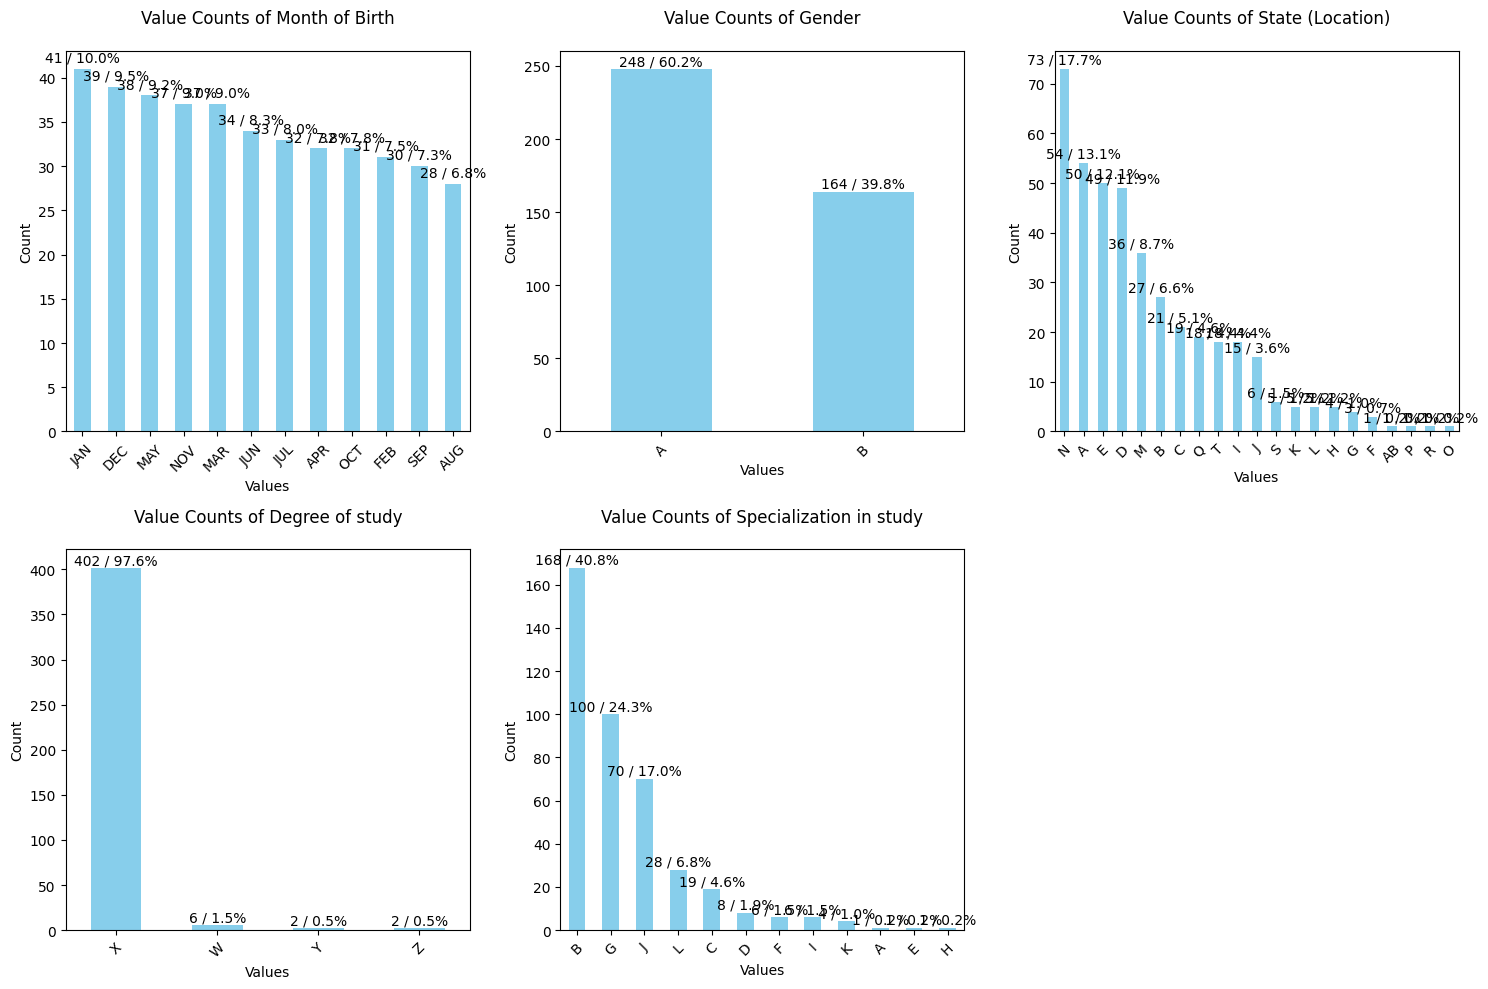

In [1205]:
plot_all_category_columns(df, categorical_columns, color='skyblue', top=40)

In [1206]:
# analyze_all_numerical_columns(df, numerical_columns)

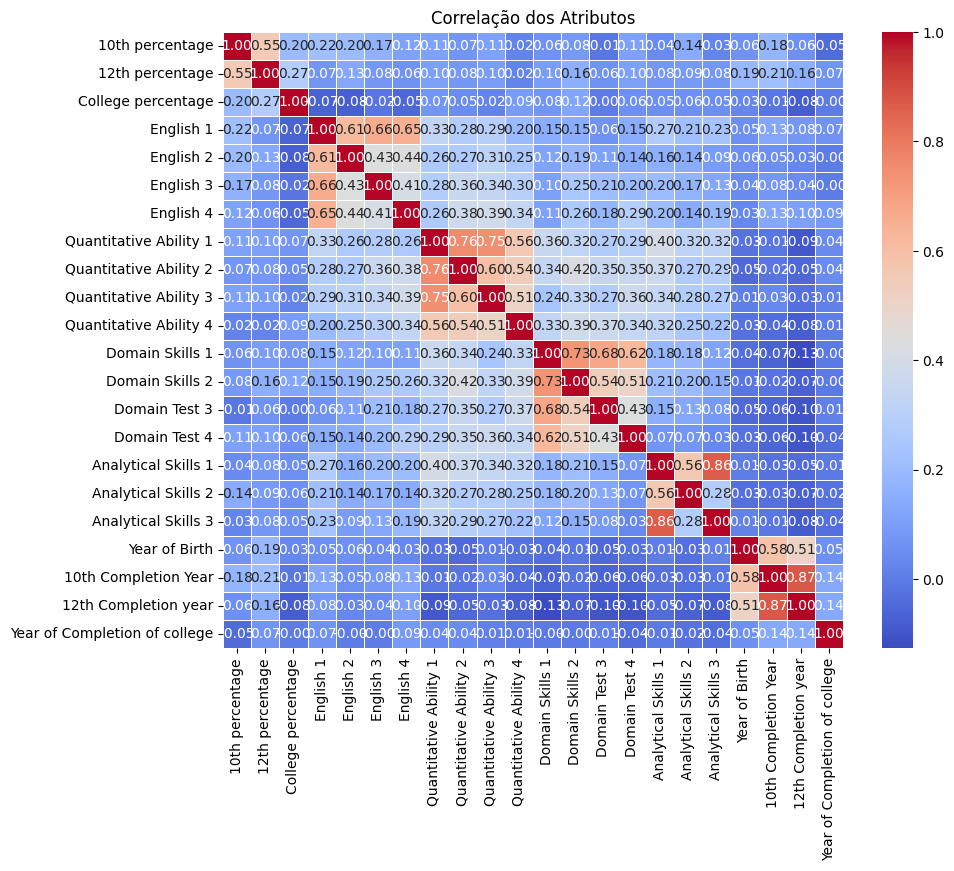

In [1207]:
correlation_heatmap(df, numerical_columns)

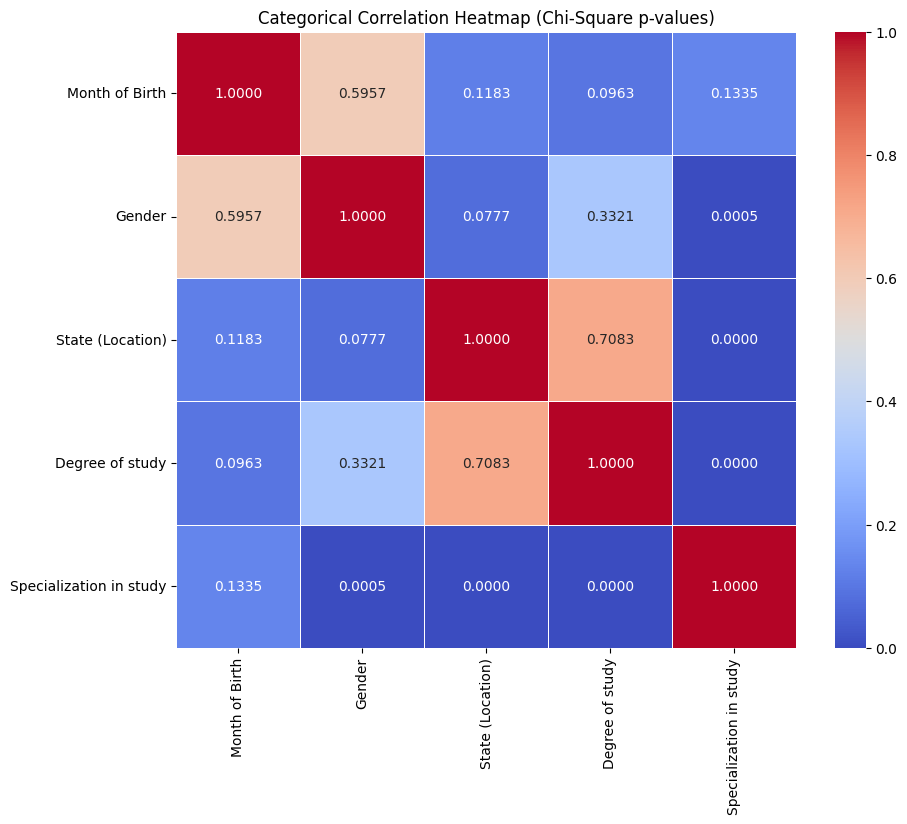

In [1208]:
categorical_correlation_chi_square(df, categorical_columns)

In [1209]:
scaled_df = scale_data(df, numerical_columns + dummy_columns)
scaled_df

,Candidate ID,Number of characters in Original Name,10th percentage,12th percentage,College percentage,English 1,English 2,English 3,English 4,Quantitative Ability 2,...,dummy_Specialization in study_E,dummy_Specialization in study_F,dummy_Specialization in study_G,dummy_Specialization in study_H,dummy_Specialization in study_I,dummy_Specialization in study_J,dummy_Specialization in study_K,dummy_Specialization in study_L,dummy_Performance_0,dummy_Performance_1
0,1056.0,11.0,-1.262800,-1.144703,0.193323,-0.797458,-1.107084,-0.520917,-0.750252,-0.423766,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,-0.671345,0.671345
1,1058.0,12.0,-0.347183,-0.854951,0.642578,0.211645,0.376993,0.317844,0.020580,-0.728995,...,-0.049326,-0.121566,1.766352,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,-0.671345,0.671345
2,1059.0,13.0,-0.725080,-0.609777,-0.569834,0.884380,1.984743,-0.520917,-0.530014,-0.932482,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,1.489547,-1.489547
3,1062.0,16.0,-0.769890,-0.832663,0.078130,-0.573213,-0.859738,-0.940298,0.130699,1.204126,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,-0.671345,0.671345
4,1063.0,11.0,-0.317310,-0.450413,-0.798781,1.220747,1.984743,1.051760,0.020580,0.288437,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,-0.671345,0.671345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,248.0,13.0,1.007572,-1.088982,0.826888,-0.124723,0.005974,-1.149988,0.130699,1.102383,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,3.703280,-0.671345,0.671345
462,85.0,16.0,-0.605587,0.970484,0.740493,-1.133825,-0.365046,-0.625763,-0.970489,-0.220279,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,-0.671345,0.671345
463,474.0,9.0,0.947825,-0.988683,-0.901016,1.893482,-0.365046,1.995366,-0.860371,1.000640,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,-0.671345,0.671345
464,318.0,13.0,0.260739,-0.074851,0.888804,0.548012,0.995358,0.842069,-0.640133,0.491924,...,-0.049326,-0.121566,-0.566139,-0.049326,-0.121566,-0.452414,-0.099015,-0.270031,1.489547,-1.489547


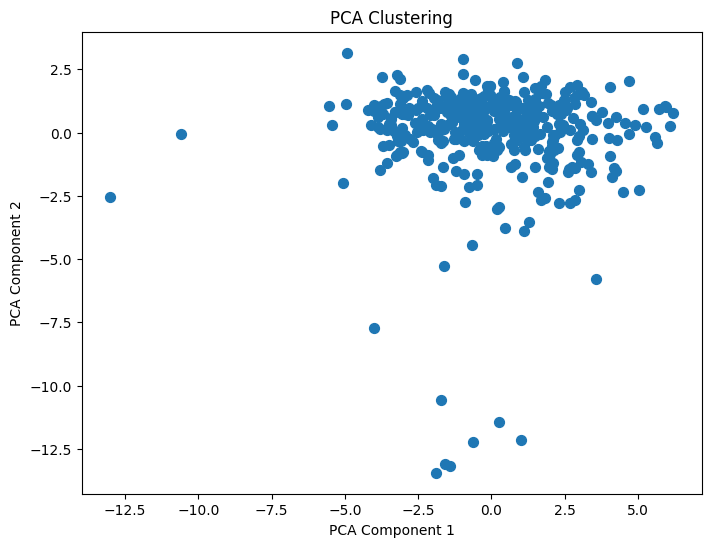

contribuiçoes de cada pca: [0.0954 0.0671 0.0452 0.0431 0.0349]


{'PCA1': {'Quantitative Ability 2': np.float64(0.3112069054583452),
  'Quantitative Ability 1': np.float64(0.30733967882529833),
  'Quantitative Ability 3': np.float64(0.2847730546913017),
  'Domain Skills 2': np.float64(0.27275526123277344),
  'Quantitative Ability 4': np.float64(0.2681190929177357)},
 'PCA2': {'10th Completion Year': np.float64(0.37233830577736277),
  'dummy_Degree of study_X': np.float64(0.37062192644842346),
  '12th Completion year': np.float64(0.36767108934290116),
  'dummy_Specialization in study_F': np.float64(0.36187153654177545),
  'dummy_Degree of study_W': np.float64(0.3618715365417754)},
 'PCA3': {'12th percentage': np.float64(0.39569252780052055),
  'College percentage': np.float64(0.3251058123137812),
  'dummy_State (Location)_A': np.float64(0.2961302882713956),
  '10th percentage': np.float64(0.2956516105805958),
  'dummy_Specialization in study_I': np.float64(0.256543682035193)},
 'PCA4': {'Domain Skills 1': np.float64(0.30791167288223764),
  'dummy_Spe

In [1210]:
pca_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns + dummy_columns)

print(f"contribuiçoes de cada pca: {pca_contributions}")
loadings

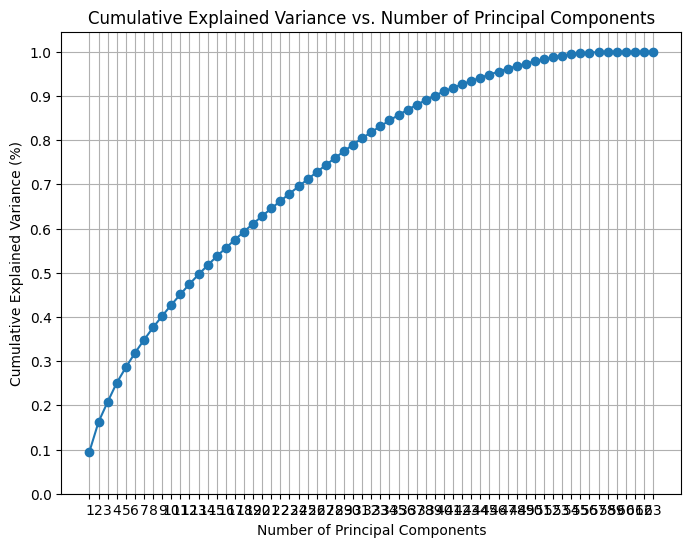

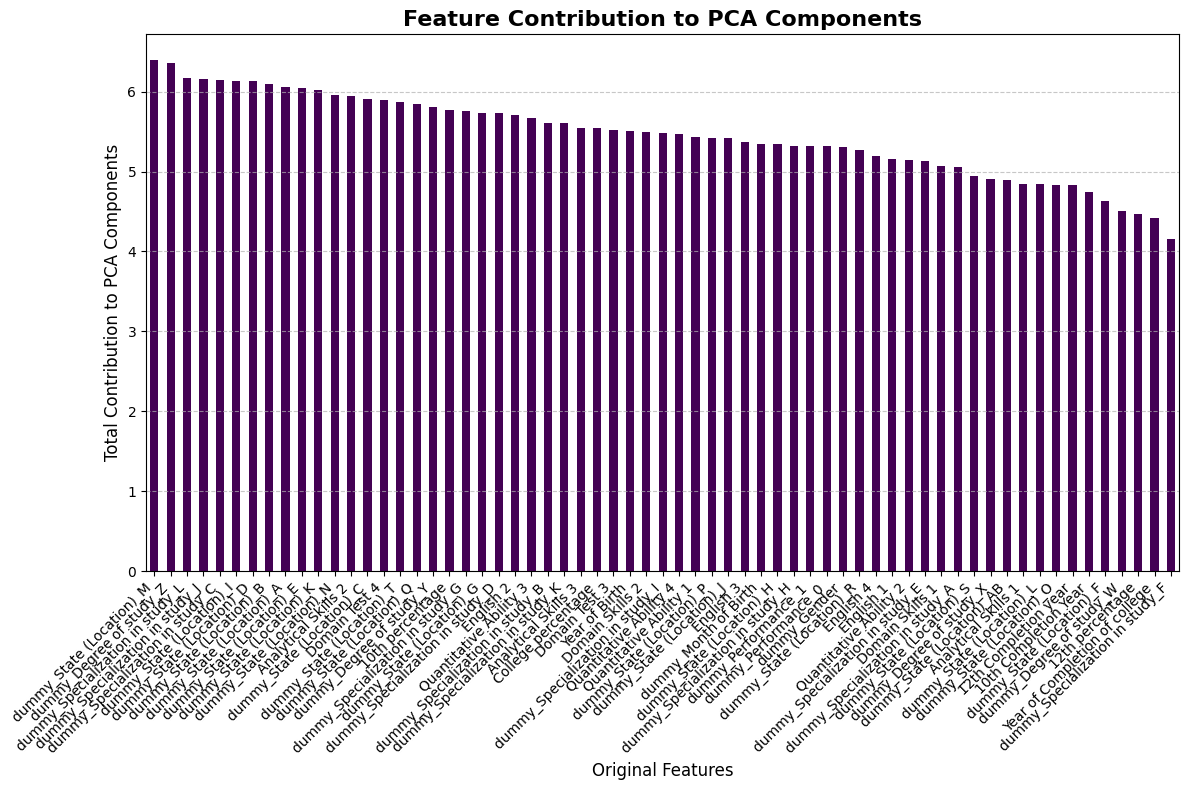

In [1211]:
cumulative_explained_variance, feature_contributions = pca_explained_variance_plot(scaled_df, columns=numerical_columns + dummy_columns)

In [1212]:
pca_df = pca_df[[f"pca{i}"for i in range(1, 40)]]
pca_df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39
0,1.016600,0.222025,-0.907290,-1.298501,-2.719028,1.993996,0.002244,0.100516,-0.754273,-1.627049,...,1.305751,-2.031110,-1.820343,-0.307642,-0.427946,0.415195,-0.080720,-0.064915,0.867040,-0.607584
1,0.782083,0.276988,-0.137566,-0.402034,-2.224332,0.694265,1.565593,-0.896558,-0.332498,-0.462202,...,-0.803893,-0.155616,1.121263,-0.444774,-0.054943,1.304937,0.751216,0.224797,0.525603,-1.223023
2,-1.581221,1.589507,-1.364258,-0.742298,1.563614,0.598337,-0.785991,0.536583,-0.066609,-2.517526,...,1.968653,-0.787640,-1.638453,0.830966,-0.307752,-0.197574,-0.498631,0.537804,1.532542,0.592881
3,1.102899,0.091670,-0.839645,0.231949,-2.227911,1.620970,-0.600581,1.372121,-0.052017,-0.286732,...,0.025423,-1.042567,0.754068,-0.106355,-1.444096,1.188235,-0.740967,-0.071463,-0.014927,-0.940310
4,1.508357,0.879353,-0.014613,1.354318,1.677143,-1.349435,1.566273,0.529347,0.474576,0.455054,...,0.054229,-0.772282,-0.115579,0.391540,-0.605970,-1.634885,-2.580275,1.200079,-0.888994,-0.608000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.267760,-2.944147,-1.180146,-2.984598,-1.839731,-2.596679,-2.523275,-2.007474,-0.476370,4.126315,...,0.462486,-0.645372,-0.595994,5.076186,1.400566,-1.250016,3.612031,-0.299285,-0.952631,-0.871191
462,-0.142971,0.493589,1.811878,0.366819,-1.613712,0.032027,-0.055584,0.356962,-0.559013,-0.592761,...,0.195602,-0.953438,-0.668230,-0.674341,-0.251408,0.122252,-0.152749,-2.021656,-0.826828,0.615048
463,1.497868,-0.129656,-0.186747,-2.778973,-1.244754,-1.043029,1.118537,-0.056670,0.598938,-0.383522,...,-0.884188,1.443416,1.793011,0.479957,-1.134704,-0.488431,-0.013995,0.716584,0.763363,-0.227837
464,-1.229582,0.795769,-0.020628,0.611991,2.441005,-0.191742,-1.379337,0.260495,0.151032,-1.647435,...,-0.134707,0.610524,0.787230,0.187398,-1.186296,-1.573002,-0.322119,0.053864,-0.144762,0.272645


In [1213]:
classifier, accuracy = decision_tree_classifier(scaled_df, numerical_columns + dummy_columns, y_column)
print(f'Acurácia: {accuracy}')

Acurácia: 1.0
